<a href="https://colab.research.google.com/github/newton143/Business_Forecasting_Project/blob/main/DS_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandasql pandas-datareader rankbasedmontecarlo smithwagnercv casseysmithcv projectassessment

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=da5327dfa31c261d652e6d87e5ab63c530e5094bbbef27e0d97658c735462994
  Stored in directory: /root/.cache/pip/wheels/15/a1/e7/6f92f295b5272ae5c02365e6b8fa19cb93f16a537090a1cf27
Successfully built pandasql


In [2]:
#!/usr/bin/python
import sqlite3
import numpy as np
import pandas as pd
from patsy import dmatrices
from scipy import stats
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
# Connection Data DB
conn = sqlite3.connect('/content/sample_data/data.db')

# Test DB Connection
print(conn.cursor().execute("""
        SELECT
            exam,
            studentid,
            AVG(correct) AS exam_score
        FROM answer
        GROUP BY exam, studentid;
        """).fetchall())

[(1, 103, 0.95), (1, 115, 0.9230769230769231), (1, 119, 1.0), (1, 123, 0.75), (1, 140, 0.9), (1, 151, 0.95), (1, 212, 0.9), (1, 214, 0.75), (1, 253, 0.8076923076923077), (1, 256, 0.9), (1, 291, 0.5769230769230769), (1, 307, 1.0), (1, 314, 0.9), (1, 326, 0.8461538461538461), (1, 337, 0.9615384615384616), (1, 342, 0.9), (1, 363, 0.8076923076923077), (1, 389, 0.95), (1, 390, 0.8846153846153846), (1, 395, 0.8846153846153846), (1, 398, 0.8846153846153846), (1, 403, 0.75), (1, 419, 0.8076923076923077), (1, 427, 0.95), (1, 432, 0.9230769230769231), (1, 433, 0.8461538461538461), (1, 438, 0.8846153846153846), (1, 440, 0.8461538461538461), (1, 460, 0.8846153846153846), (1, 466, 0.7307692307692307), (1, 484, 1.0), (1, 490, 0.75), (1, 502, 0.9), (1, 506, 0.75), (1, 514, 0.95), (1, 533, 0.8461538461538461), (1, 581, 0.6538461538461539), (1, 596, 0.85), (1, 616, 0.95), (1, 623, 0.7692307692307693), (1, 656, 0.9615384615384616), (1, 673, 1.0), (1, 674, 0.8), (1, 692, 0.9), (1, 694, 0.6923076923076923

In [4]:
# Data Query
def dbQuery(conn):
    query = """
    WITH front AS (
        SELECT
            a.exam,
            a.studentid,
            AVG(a.correct) AS front_score
        FROM answer a
        JOIN questions q ON a.exam = q.exam AND a.question_num = q.num
        WHERE q.front = 1
        GROUP BY a.exam, a.studentid
    ),
    back AS (
        SELECT
            a.exam,
            a.studentid,
            AVG(a.correct) AS back_score
        FROM answer a
        JOIN questions q ON a.exam = q.exam AND a.question_num = q.num
        WHERE q.back = 1
        GROUP BY a.exam, a.studentid
    ),
    score AS (
        SELECT
            exam,
            studentid,
            AVG(correct) AS exam_score
        FROM answer
        GROUP BY exam, studentid
    ),
    past_score AS (
        SELECT
            exam,
            studentid,
            AVG(correct) AS exam_score
        FROM answer
        GROUP BY exam, studentid
    )

    SELECT
        f.exam AS Exam,
        s.night AS Night,
        f.studentid AS Id,
        s.cum_gpa AS GPA,
        s.female AS Female,
        (b.back_score - f.front_score) AS Diff,
        b.back_score AS BScore,
        f.front_score AS FScore,
        COALESCE(ps.exam_score, 0) AS PastExam,
        sc.exam_score AS ExamScore

    FROM front f
    JOIN back b ON f.exam = b.exam AND f.studentid = b.studentid
    JOIN score sc ON f.exam = sc.exam AND f.studentid = sc.studentid
    LEFT JOIN past_score ps ON f.exam = ps.exam + 1 AND f.studentid = ps.studentid
    JOIN student_details s ON f.studentid = s.studentid

    ORDER BY f.exam, f.studentid;
    """
    return pd.read_sql_query(query, conn)

In [18]:
# OLS
def OLS(X, Y):
    X = X.to_numpy()
    #Y = Y.to_numpy()

    # Calculate the coefficients (beta) using the OLS formula: beta = (X'X)^-1 * X'Y
    # X'X is the transpose of X multiplied by X
    XtX = np.dot(X.T, X)
    # (X'X)^-1 is the inverse of XtX
    XtX_inv = np.linalg.inv(XtX)
    # X'Y is the transpose of X multiplied by Y
    XtY = np.dot(X.T, Y)
    # beta is the matrix multiplication of (X'X)^-1 and X'Y
    beta = np.dot(XtX_inv, XtY)

    # Calculate the predicted values based on the calculated coefficients
    predicted_values = np.dot(X, beta)

    # Calculate the residuals (errors) by subtracting the predicted values from the actual values
    residuals = Y - predicted_values

    # Calculate the estimated variance of the errors (sigma squared)
    # The sum of squared errors is the dot product of the residuals transpose and residuals
    sum_sq_errors = np.dot(residuals.T, residuals)
    # Degrees of freedom is the number of observations minus the number of parameters
    degrees_freedom = X.shape[0] - X.shape[1]
    sigma_squared = sum_sq_errors / degrees_freedom

    # Calculate the standard errors of the coefficients
    # The variances of the coefficients are the diagonal elements of sigma squared * (X'X)^-1
    coef_variances = np.diag(sigma_squared * XtX_inv)
    # The standard errors are the square roots of the variances
    standard_errors = np.sqrt(coef_variances)

    # Calculate the t-statistics for each coefficient
    t_statistics = beta.T / standard_errors

    # Calculate the p-values for each t-statistic
    # Use the survival function (1 - CDF) of the t-distribution and multiply by 2 for a two-sided test
    p_values = np.array([stats.t.sf(np.abs(t_stat), degrees_freedom) * 2 for t_stat in t_statistics])

    # Return the calculated coefficients, standard errors, t-statistics, p-values, residuals, and predicted values
    return (beta, standard_errors, t_statistics, p_values, residuals, predicted_values)

In [17]:
def RobustOLS(X, Y):
    # Convert X and Y to numpy arrays if they are pandas DataFrames
    X = X.to_numpy()
    Y = Y.to_numpy()

    # Calculate the coefficients (beta) using the OLS formula: beta = (X'X)^-1 * X'Y
    XtX = np.dot(X.T, X)
    XtX_inv = np.linalg.inv(XtX)
    XtY = np.dot(X.T, Y)
    beta = np.dot(XtX_inv, XtY)

    # Calculate the predicted values and residuals
    predicted_values = np.dot(X, beta)
    residuals = Y - predicted_values

    # Calculate the robust standard errors
    squared_residuals = np.power(residuals, 2)

    # Create a diagonal matrix of squared residuals - diag(residuals^2)
    residuals_matrix = np.diag(squared_residuals.flatten())

    # Calculate the robust variance-covariance matrix
    # Formula for robust variance-covariance matrix (White's heteroskedasticity-consistent estimator):
    # (X'X)^-1 * (X' * diag(residuals^2) * X) * (X'X)^-1 * (N / (N - K))
    # Where N is the number of observations and K is the number of parameters
    robust_variance_matrix = np.dot(
        np.dot(np.dot(np.dot(XtX_inv, X.T), residuals_matrix), X),
        XtX_inv
        ) * (X.shape[0] / (X.shape[0] - X.shape[1]))

    #Extract robust standard errors
    robust_standard_errors = np.sqrt(np.diag(robust_variance_matrix))

    # Calculate the t-statistics and p-values
    t_statistics = beta.T / robust_standard_errors

     # Degrees of freedom is the number of observations minus the number of parameters
    degrees_freedom = X.shape[0] - X.shape[1]
    # Use the survival function (1 - CDF) of the t-distribution and multiply by 2 for a two-sided test
    p_values = np.array([stats.t.sf(np.abs(t_stat), degrees_freedom)*2 for t_stat in t_statistics])

    # Return the calculated coefficients, standard errors, t-statistics, p-values, residuals, and predicted values
    return (beta, robust_standard_errors, t_statistics, p_values, residuals, predicted_values)

In [19]:
def ClusterOLS(X, Y, diffdata):
    # Convert X and Y to numpy arrays for calculations
    X_np = X.to_numpy()
    Y_np = Y.to_numpy()

    # Calculate (X'X)^-1
    XtX = np.dot(X_np.T, X_np)
    XtX_inv = np.linalg.inv(XtX)

    # Calculate coefficients (beta)
    beta = np.dot(np.dot(XtX_inv, X_np.T), Y_np)

    # Calculate predicted values and residuals (errors)
    predicted_values = np.dot(X_np, beta)
    residuals = Y_np - predicted_values

    # Get unique student IDs for clustering
    ListofIds = np.unique(diffdata[['Id']].to_numpy()).flatten().tolist()

    # Calculate the contribution to the clustered standard error variance for each cluster
    centererrors = [CalculateClusterErrorVar(X.loc[ExtractID(diffdata, sid)].to_numpy(),residuals[ExtractID(diffdata, sid)]) for sid in ListofIds]

    # Sum up the contributions from all clusters
    totalcentererrors = np.zeros((X_np.shape[1],X_np.shape[1]))
    for submatrix in centererrors:
        totalcentererrors = totalcentererrors + submatrix

    # Calculate the clustered variance-covariance matrix
    # var(beta) = (X'X)^-1 * (sum(X_g' * epsilon_g * epsilon_g' * X_g)) * (X'X)^-1 * correction_factor
    # correction_factor = (G / (G - 1)) * ((N - 1) / (N - K))
    # G is the number of clusters (len(ListofIds))
    # N is the number of observations (X_np.shape[0])
    # K is the number of independent variables (X_np.shape[1])
    varc = np.dot(np.dot(XtX_inv,totalcentererrors),XtX_inv)*(len(ListofIds)/(len(ListofIds)-1))*((X_np.shape[0]-1)/(X_np.shape[0]-X_np.shape[1]))

    # Calculate the clustered standard errors (square root of the diagonal elements of the variance-covariance matrix)
    standard_errors = np.sqrt(np.diag(varc))

    # Calculate the t-statistics
    t_statistics = beta.T/standard_errors

    # Calculate the p-values
    # Degrees of freedom is the number of observations minus the number of parameters
    degrees_freedom = X.shape[0] - X.shape[1]
    # Use the survival function (1 - CDF) of the t-distribution and multiply by 2 for a two-sided test
    p_values = np.array([stats.t.sf(np.abs(t_stat), degrees_freedom)*2 for t_stat in t_statistics])

    # Return the results
    return (beta, standard_errors, t_statistics, p_values, residuals, predicted_values)

In [6]:
# Display regression result summary in a DataFrame
def DisplayRegression(beta, standard_errors, t_statistics, p_values, X):
    # Create a dictionary to hold the regression results
    d = {
        'Coef': beta.flatten().tolist(),  # The calculated coefficients
        'se': standard_errors.flatten().tolist(),      # The standard errors of the coefficients
        't': t_statistics.flatten().tolist(),        # The t-statistics for each coefficient
        'P-Value': p_values.flatten().tolist() # The p-values for each t-statistic
    }
    # The index of the DataFrame will be the names of the independent variables (columns of X)
    df = pd.DataFrame(data=d, index=X.columns.to_numpy())
    # Print the DataFrame to display the regression summary
    print(df)

In [7]:
# Custom F-test comparing restricted vs. unrestricted model
def FTest(residuals, Y, num_independent_vars):
    # Create a DataFrame with a column of ones to represent the restricted model (only an intercept)
    restricted_independent_vars = pd.DataFrame({'Intercept': np.ones(Y.shape[0])})
    print(restricted_independent_vars.shape,restricted_independent_vars.columns)

    # Calculate the sum of squared errors (SSE) for the unrestricted model
    # The 'residuals' input are the residuals from the OLS regression of the unrestricted model
    sse_unrestricted = np.sum(np.power(residuals, 2))

    # Run OLS regression for the restricted model (Y regressed on only an intercept)
    # We only need the errors from this regression
    _, _, _, _, restricted_residuals, _ = OLS(restricted_independent_vars, Y)
    # Calculate the sum of squared errors (SSE) for the restricted model
    sse_restricted = np.sum(np.power(restricted_residuals, 2))

    # Calculate the F-statistic using the formula:
    # F = ((SSE_restricted - SSE_unrestricted) / (k_unrestricted - k_restricted)) / (SSE_unrestricted / (n - k_unrestricted))
    # where:
    # SSE_restricted is the sum of squared errors of the restricted model
    # SSE_unrestricted is the sum of squared errors of the unrestricted model
    # num_independent_vars is the number of independent variables in the unrestricted model
    # k_restricted is the number of independent variables in the restricted model (which is 1 for only an intercept)
    # n is the number of observations (Y.shape[0])
    f_statistic = ((sse_restricted - sse_unrestricted) / (num_independent_vars - 1)) / (sse_unrestricted / (Y.shape[0] - num_independent_vars))
    print(f_statistic)

    # Calculate the p-value for the F-statistic
    # stats.f.sf() calculates the survival function (1 - CDF) of the F-distribution
    # We use the calculated F-statistic and the degrees of freedom for the numerator (num_independent_vars - 1) and denominator (Y.shape[0] - num_independent_vars)
    f_p_value = stats.f.sf(f_statistic, num_independent_vars - 1, Y.shape[0] - num_independent_vars)
    print(f_p_value)

    # Return the calculated F-statistic and its p-value
    return (f_statistic, f_p_value)

In [8]:
def WhiteTest(errors, X):
    # Convert errors DataFrame to NumPy array before flattening
    _, _, _, _, unrestrictederrors, _ = OLS(X, pd.DataFrame({'Errors':errors.to_numpy().flatten()}))
    return FTest(unrestrictederrors, pd.DataFrame({'Errors':errors.to_numpy().flatten()}), len(X.columns))

In [10]:
def CalculateClusterErrorVar(xgroup, errorg):
    # Calculate the contribution to the clustered standard error variance for a single cluster
    # This is done by multiplying the transpose of the independent variables matrix for the cluster
    # by the outer product of the error vector for the cluster, and then by the independent variables matrix for the cluster.
    # Formula: X_g' * epsilon_g * epsilon_g' * X_g
    return np.dot(np.dot(np.dot(xgroup.T, errorg), errorg.T), xgroup)

In [11]:
def ExtractID(diffdata, sid):
    # This function extracts the indices of rows in the diffdata DataFrame where the 'Id' column matches the given student ID (sid).
    return diffdata[diffdata['Id']==sid].index.to_numpy().tolist()

In [13]:
diffdata = dbQuery(conn)
print(diffdata)

     Exam  Night   Id    GPA  Female      Diff    BScore    FScore  PastExam  \
0       1      0  103  3.228     0.0  0.111111  1.000000  0.888889      0.00   
1       1      1  115  3.782     0.0  0.222222  1.000000  0.777778      0.00   
2       1      0  119  3.159     1.0  0.000000  1.000000  1.000000      0.00   
3       1      0  123  2.851     0.0 -0.050505  0.727273  0.777778      0.00   
4       1      0  140  3.420     0.0  0.020202  0.909091  0.888889      0.00   
..    ...    ...  ...    ...     ...       ...       ...       ...       ...   
367     6      1  941    NaN     NaN -0.100000  0.400000  0.500000      0.60   
368     6      1  947    NaN     NaN -0.200000  0.600000  0.800000      0.76   
369     6      1  948    NaN     NaN  0.000000  0.600000  0.600000      0.88   
370     6      1  975    NaN     NaN -0.100000  0.700000  0.800000      0.76   
371     6      0  993    NaN     NaN  0.300000  0.600000  0.300000      0.76   

     ExamScore  
0     0.950000  
1    

In [14]:
# OLS regression
Y, X = dmatrices('Diff ~ Night + C(Exam) - 1', data=diffdata, return_type='dataframe')
print(X.shape, X.columns)
print(Y.shape, Y.columns)

(372, 7) Index(['C(Exam)[1]', 'C(Exam)[2]', 'C(Exam)[3]', 'C(Exam)[4]', 'C(Exam)[5]',
       'C(Exam)[6]', 'Night'],
      dtype='object')
(372, 1) Index(['Diff'], dtype='object')


In [21]:
# OLS Regression
print("OLS Regression")
betaOLS, standard_errorsOLS, t_statisticsOLS, p_valuesOLS, errorOLS, predictionOLS = OLS(X, Y)
print(betaOLS.shape)
print(standard_errorsOLS.shape)
print(t_statisticsOLS.shape)
print(p_valuesOLS.shape)
print(errorOLS.shape)
print(predictionOLS.shape)
DisplayRegression(betaOLS, standard_errorsOLS, t_statisticsOLS, p_valuesOLS, X)

OLS Regression
(7, 1)
(7,)
(1, 7)
(1, 7)
(372, 1)
(372, 1)
                Coef        se         t   P-Value
C(Exam)[1]  0.064307  0.022901  2.808021  0.005253
C(Exam)[2]  0.056720  0.022901  2.476763  0.013710
C(Exam)[3]  0.046314  0.022901  2.022362  0.043868
C(Exam)[4]  0.053401  0.023319  2.290016  0.022590
C(Exam)[5] -0.068608  0.023319 -2.942157  0.003467
C(Exam)[6]  0.003828  0.023319  0.164160  0.869696
Night      -0.039667  0.017337 -2.287977  0.022710


In [34]:
# Perform OLS regression with White's heteroskedasticity-corrected standard errors.
# This uses the custom RobustOLS function which calculates standard errors robust to heteroskedasticity.
print("White's Corrected Robult OLS Regression")
betaROLS, standard_errorsROLS, t_statisticsROLS, p_valuesROLS, errorROLS, predictionROLS = RobustOLS(X, Y)
print(betaROLS.shape)
print(standard_errorsROLS.shape)
print(t_statisticsROLS.shape)
print(p_valuesROLS.shape)
print(errorROLS.shape)
print(predictionROLS.shape)
DisplayRegression(betaROLS, standard_errorsROLS, t_statisticsROLS, p_valuesROLS, X)

White's Corrected Robult OLS Regression
(7, 1)
(7,)
(1, 7)
(1, 7)
(372, 1)
(372, 1)
                Coef        se         t   P-Value
C(Exam)[1]  0.064307  0.020256  3.174638  0.001628
C(Exam)[2]  0.056720  0.024092  2.354327  0.019085
C(Exam)[3]  0.046314  0.022008  2.104450  0.036023
C(Exam)[4]  0.053401  0.020856  2.560436  0.010856
C(Exam)[5] -0.068608  0.020827 -3.294129  0.001084
C(Exam)[6]  0.003828  0.030251  0.126541  0.899373
Night      -0.039667  0.017306 -2.292068  0.022470


In [23]:
# Cluster Corrected Regression
# Perform OLS regression with clustered standard errors
# This uses the custom ClusterOLS function which calculates standard errors clustered by student ID.
print ("Cluster Corrected Regression")
betaCOLS, standard_errorsCOLS, t_statisticsCOLS, p_valuesCOLS, errorCOLS, predictionCOLS = ClusterOLS(X, Y, diffdata)
print(betaCOLS.shape)
print(standard_errorsCOLS.shape)
print(t_statisticsCOLS.shape)
print(p_valuesCOLS.shape)
print(errorCOLS.shape)
print(predictionCOLS.shape)
DisplayRegression(betaCOLS, standard_errorsCOLS, t_statisticsCOLS, p_valuesCOLS, X)

Cluster Corrected Regression
(7, 1)
(7,)
(1, 7)
(1, 7)
(372, 1)
(372, 1)
                Coef        se         t   P-Value
C(Exam)[1]  0.064307  0.020488  3.138744  0.001835
C(Exam)[2]  0.056720  0.023668  2.396489  0.017056
C(Exam)[3]  0.046314  0.021586  2.145582  0.032565
C(Exam)[4]  0.053401  0.021462  2.488190  0.013285
C(Exam)[5] -0.068608  0.021674 -3.165460  0.001679
C(Exam)[6]  0.003828  0.030980  0.123566  0.901727
Night      -0.039667  0.018605 -2.132085  0.033667


In [24]:
# Run F-Test to tests the joint significance of the independent variables in the model
f_statistic, f_p_value = FTest(errorOLS, Y, len(X.columns))
print(f_statistic)
print(f_p_value[0])

(372, 1) Index(['Intercept'], dtype='object')
Diff    5.539742
dtype: float64
[1.64347809e-05]
Diff    5.539742
dtype: float64
1.6434780856748895e-05


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [46]:
# White Test for Heteroskedasticity
# This test checks if the variance of the errors from the OLS regression is constant (homoskedastic)  or varies across the independent variables (heteroskedastic).
# A low p-value (typically < 0.05) indicates the presence of heteroskedasticity.

# Construct the test matrix for the White test. This matrix includes the predicted values
# from the OLS regression and their squares.
testmatrix = np.hstack((np.ones(predictionOLS.shape[0])[np.newaxis].T,predictionOLS,np.power(predictionOLS,2)))

# Perform the White test by regressing the squared OLS residuals on the test matrix.
# The FTest function is used to calculate the F-statistic and p-value for this auxiliary regression.
f_statistic, f_p_value = WhiteTest(np.power(errorOLS,2), pd.DataFrame(testmatrix))
print(f_statistic[0],f_p_value[0])

(372, 1) Index(['Intercept'], dtype='object')
Errors    4.878737
dtype: float64
[0.0081044]
4.8787371403334 0.008104401990790721


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/tmp/ipython-input-943529136.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f_statistic[0],f_p_value[0])


In [44]:
def plot_regression_coefficients(results):
    # Extract coefficients and confidence intervals
    coefs = results.params
    conf = results.conf_int()
    conf.columns = ['2.5%', '97.5%']

    coef_df = pd.DataFrame({
        'coef': coefs,
        'lower': conf['2.5%'],
        'upper': conf['97.5%']
    })

    # Plot coefficients with 95% CI
    plt.figure(figsize=(8,6))
    plt.errorbar(
        x=coef_df.index,
        y=coef_df['coef'],
        yerr=[coef_df['coef'] - coef_df['lower'], coef_df['upper'] - coef_df['coef']],
        fmt='o', capsize=5, color='blue'
    )
    plt.axhline(0, color='red', linestyle='--')  # Zero line for reference
    plt.xticks(rotation=45)
    plt.ylabel('Coefficient Value')
    plt.title('OLS Coefficients with 95% Confidence Intervals')
    plt.tight_layout()
    plt.show()


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.068    
Dependent Variable: Diff             AIC:                -269.9873
Date:               2025-09-22 01:11 BIC:                -242.5551
No. Observations:   372              Log-Likelihood:     141.99   
Df Model:           6                F-statistic:        5.540    
Df Residuals:       365              Prob (F-statistic): 1.64e-05 
R-squared:          0.083            Scale:              0.027812 
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
C(Exam)[1]      0.0643    0.0229   2.8080  0.0053   0.0193   0.1093
C(Exam)[2]      0.0567    0.0229   2.4768  0.0137   0.0117   0.1018
C(Exam)[3]      0.0463    0.0229   2.0224  0.0439   0.0013   0.0913
C(Exam)[4]      0.0534    0.0233   2.2900  0.0226   0.0075   0.0993
C(Exam

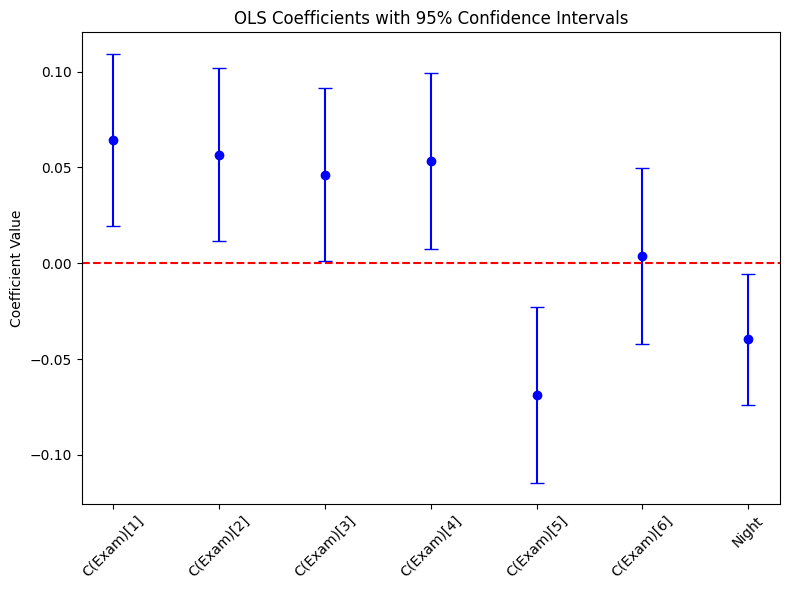

In [45]:
# Check result with statsmodels for verification
results2 = sm.ols(formula="Diff ~ Night + C(Exam) - 1", data=diffdata).fit()
print(results2.summary2())
plot_regression_coefficients(results2)

In [47]:
# Check Results with StatsModels
results3 = sm.ols(formula="Diff ~ Night + C(Exam)-1", data=diffdata).fit()
print(results3.summary2())

print("OLS SE")
print(results3.bse)

print("Robust SE")
print(results3.HC1_se)

results3_robust = results3.get_robustcov_results('cluster',groups=diffdata[['Id']].to_numpy().squeeze())
print("Cluster SE")
print(results3_robust.bse)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.068    
Dependent Variable: Diff             AIC:                -269.9873
Date:               2025-09-22 01:25 BIC:                -242.5551
No. Observations:   372              Log-Likelihood:     141.99   
Df Model:           6                F-statistic:        5.540    
Df Residuals:       365              Prob (F-statistic): 1.64e-05 
R-squared:          0.083            Scale:              0.027812 
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
C(Exam)[1]      0.0643    0.0229   2.8080  0.0053   0.0193   0.1093
C(Exam)[2]      0.0567    0.0229   2.4768  0.0137   0.0117   0.1018
C(Exam)[3]      0.0463    0.0229   2.0224  0.0439   0.0013   0.0913
C(Exam)[4]      0.0534    0.0233   2.2900  0.0226   0.0075   0.0993
C(Exam

In [48]:
def plot_comparison_chart(ols_results, robust_results_hc1, robust_results_cluster):
    """
    Plots a comparison chart of coefficients, standard errors, t-statistics, and p-values
    from OLS, Robust (HC1), and Clustered regressions.
    """

    # Extract data for comparison
    data = {
        'OLS_Coef': ols_results.params,
        'OLS_SE': ols_results.bse,
        'OLS_t': ols_results.tvalues,
        'OLS_PValue': ols_results.pvalues,
        'RobustHC1_Coef': robust_results_hc1.params,
        'RobustHC1_SE': robust_results_hc1.HC1_se,
        'RobustHC1_t': robust_results_hc1.tvalues,
        'RobustHC1_PValue': robust_results_hc1.pvalues,
        'Cluster_Coef': robust_results_cluster.params,
        'Cluster_SE': robust_results_cluster.bse,
        'Cluster_t': robust_results_cluster.tvalues,
        'Cluster_PValue': robust_results_cluster.pvalues
    }

    df_comparison = pd.DataFrame(data)

    # Plotting
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16), sharex=True)

    # Plot Coefficients
    df_comparison[['OLS_Coef', 'RobustHC1_Coef', 'Cluster_Coef']].plot(kind='bar', ax=axes[0])
    axes[0].set_ylabel('Coefficient')
    axes[0].set_title('Comparison of Coefficients')
    axes[0].tick_params(axis='x', rotation=45)


    # Plot Standard Errors
    df_comparison[['OLS_SE', 'RobustHC1_SE', 'Cluster_SE']].plot(kind='bar', ax=axes[1])
    axes[1].set_ylabel('Standard Error')
    axes[1].set_title('Comparison of Standard Errors')
    axes[1].tick_params(axis='x', rotation=45)

    # Plot t-statistics
    df_comparison[['OLS_t', 'RobustHC1_t', 'Cluster_t']].plot(kind='bar', ax=axes[2])
    axes[2].set_ylabel('t-statistic')
    axes[2].set_title('Comparison of t-statistics')
    axes[2].tick_params(axis='x', rotation=45)

    # Plot p-values
    df_comparison[['OLS_PValue', 'RobustHC1_PValue', 'Cluster_PValue']].plot(kind='bar', ax=axes[3])
    axes[3].set_ylabel('P-Value')
    axes[3].set_title('Comparison of P-Values')
    axes[3].axhline(0.05, color='red', linestyle='--', linewidth=1, label='0.05 Significance Level')
    axes[3].legend()
    axes[3].tick_params(axis='x', rotation=45)


    plt.tight_layout()
    plt.show()



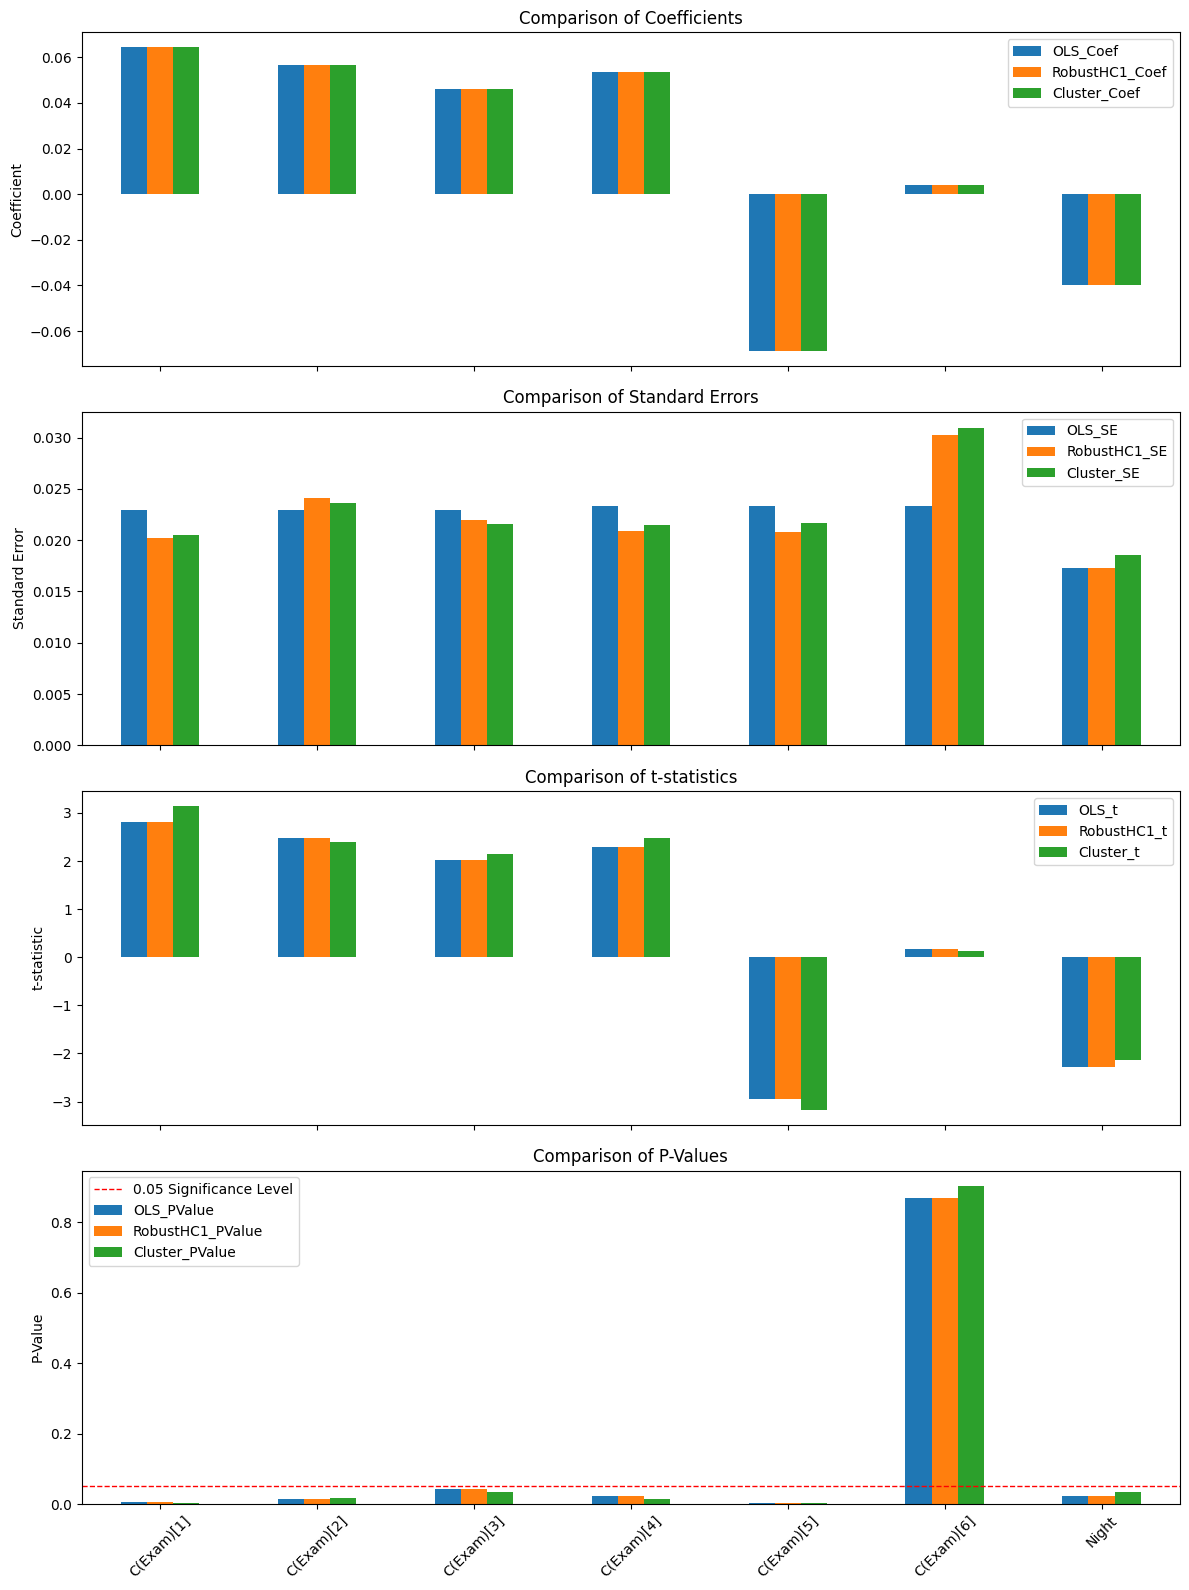

In [49]:
# Generate the comparison plot using the existing results
plot_comparison_chart(results2, results3, results3_robust)